In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [15]:
class Value:
  def __init__(self, data, _children=(), _op="", label = ""):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad # previously = 1.0 * out.grad which caused backpropogation bug when same node used twice
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad 
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), "tanh")

    def _backward():
      self.grad += (1 - t ** 2) ** out.grad
    out._backward = _backward
    
    return out 
  
  def exp(self):
    x = self.data
    e = math.exp(x)
    out = Value(e, (self,), "exp")

    def _backward():
      self.grad = e * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    # topological sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for node in reversed(topo):
      node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [16]:
za = Value(2.0)
za += 3
za = 3 + za
za

Value(data=8.0)

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

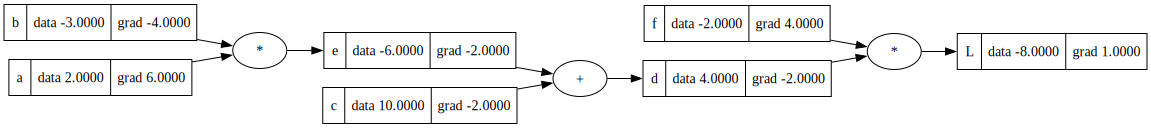

In [5]:
L.grad = 1
f.grad = 4
d.grad = -2
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

draw_dot(L)

In [6]:
def findGrad():
  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  return (L2 - L1)/h

findGrad()


0.9999999999621422

In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [ ]:
# MANUAL BACKPROPOGATION

o.grad = 1
n.grad = 1 - o.data ** 2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

#d(x2w2)/d(x2) = w2, d(o)/d(x2w2), d(o)/d(x2) = d(o)/d(x2w2) * d(x2w2)/d(x2)
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

draw_dot(o)

In [ ]:
# SEMI MANUAL BACKPROPOGATION

o.grad = 1
o._backward()
n._backward()
b._backward() # does nothing cuz leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(0)

In [ ]:
# AUTO BACKPROPOGATION

o.grad = 1

# topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

# implement this functionality into the class

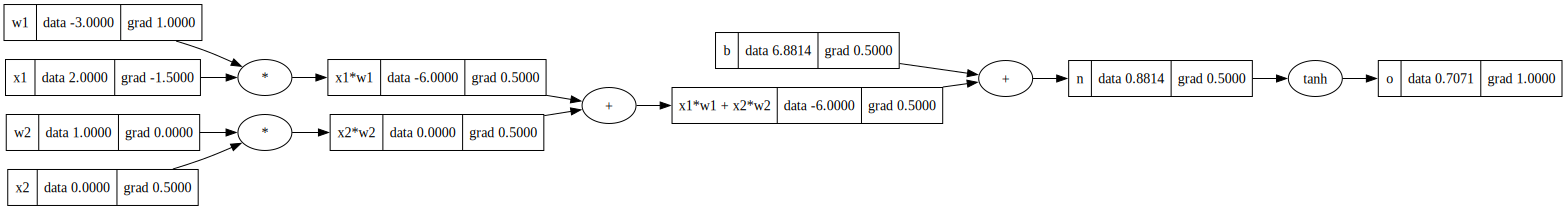

In [8]:
# BACKPROPOGATION USING CLASS BACKWARD FUNCTION

o.backward()
draw_dot(o)

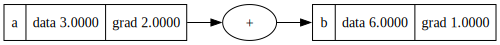

In [9]:
# BACKPROPOGATION BUG WHEN SAME NODE USED TWICE - 1, FIXED BY ACCUMULATING GRADIENTS INSTEAD OF SETTING THEM

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

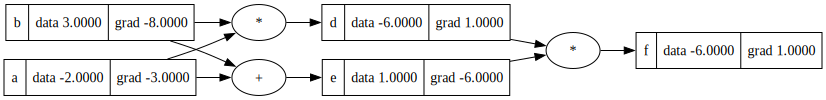

In [10]:
# BACKPROPOGATION BUG WHEN SAME NODE USED TWICE - 2

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)